# RGI-07: Region 11 (Central Europe)
##### F. Roura-Adseiras, November 2021

Goal: same as RGI6

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import numpy as np
from utils import mkdir

## Files and storage paths

In [2]:
# Region of interest
reg = 11

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '11_rgi60_CentralEurope.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions

In [4]:
toprint = []
for subid in shp.subm_id.unique():
    s_loc = shp.loc[shp.subm_id == subid]
    s = ''
    for c in ['subm_id', 'analysts', 'src_date']:
        toprint = s_loc[c].unique()
        if c != 'src_date':
            s += ' ' + (str(toprint[0]))
        else:
            for d in toprint:
                s += ' ' + d[:4]
    print(s)

 1.0 Taschner, Stefan 2001
 301.0 Taschner, Stefan 2003
 501.0 Iacovelli, Laura 2003
 531.0 Rott, Helmut; Schicker, Irene; Schwaizer (nee Bippus), Gabriele 2003
 532.0 Schicker, Irene; Schwaizer (nee Bippus), Gabriele 1985
 533.0 Paul, Frank 1998
 558.0 Vantadori, Federico 2007
 568.0 Rabatel, Antoine 2004 2003 2003
 569.0 Rabatel, Antoine 1988 1985 1985 1986 1987
 579.0 Fischer, Mauro 2009
 593.0 Paul, Frank 2003 2003 2003 2003 2003
 594.0 Wipf, Andreas 1850
 595.0 Maisch, Max 1850
 596.0 Fischer, Mauro 2008
 598.0 Paul, Frank 1999
 599.0 Benz, Christof; Wipf, Andreas 1973
 601.0 Fischer, Andrea; Kuhn, Michael; Lambrecht, Astrid 1969
 602.0 Fischer, Andrea; Kuhn, Michael; Lambrecht, Astrid 1998
 603.0 Fischer, Andrea 2012
 613.0 Fischer, Andrea 1850
 615.0 Smiraglia, Claudio 2011
 640.0 Antoine, Rabatel 2004
 641.0 Antoine, Rabatel 1971 1967 1970 1971 1949 1939
 663.0 Nemec, Johanna; Schwaizer (nee Bippus), Gabriele 2015
 664.0 Nemec, Johanna; Schwaizer (nee Bippus), Gabriele 2016
 66

## Apply selection criteria to reproduce RGI-6 for this region and check result

### Step 1: extract RGI6 from GLIMS data and do a check

In [5]:
# For Alps we use 'subm_id' = 731 as our main dataset
RGI_a = shp.loc[shp['subm_id'] == 731].copy()

# For Pyrenees we use 'subm_id' = 715 as our main dataset
RGI_p = shp.loc[shp['subm_id'] == 715].copy()

`subm_id == 580` is exactly equivalent to the old `shp['geog_area']=='Randolph Glacier Inventory'`

<AxesSubplot:>

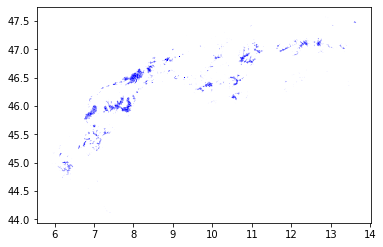

In [56]:
# Plot Alpine glaciers
RGI_a.geometry.plot(color='blue')

<AxesSubplot:>

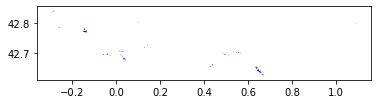

In [55]:
#Plot Pyrenean glaciers
RGI_p.geometry.plot(color='blue')

<AxesSubplot:>

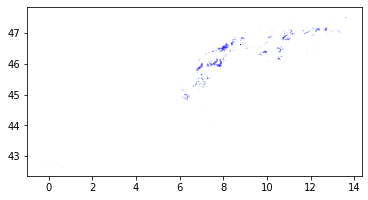

In [59]:
# Merge original RGI 580 (without the glacier in the box) and the RGI 729
RGI_ss = pd.concat([RGI_a, RGI_p])
RGI_ss.geometry.plot(color='blue')

#### load reference data (here RGI6) to enable comparison

In [61]:
# Just to know the name of the file to open from zip
import zipfile

with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        if '.shp' in f.filename:
            fname = f.filename

# load reference data
ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)

#### Number of elements (differences do not necessarily depict major problems)

In [62]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 4107
Number of glaciers in reference data: 3927
Difference: 180


#### check for duplicate glacier IDs

In [63]:
print ('number of glaciers without unique id in RGI06:', len(ref_odf)-len(ref_odf['GLIMSId'].unique()))

number of glaciers without unique id in RGI06: 5


In [64]:
print ('number of glaciers without unique id in RGI06 from GLIMS data base:', len(RGI_ss)-len(RGI_ss['glac_id'].unique()))

number of glaciers without unique id in RGI06 from GLIMS data base: 0


#### Check for 'nominal glaciers' in the RGI6 original data and delete them from new RGI subset from GLIMS if they are in there 

In [65]:
# how many nominals in RGI06 (identifiable via 'Status' attribute in RGI 06)
nom = ref_odf.loc[ref_odf.Status == 2]
len(nom)

2

In [66]:
# drop nominal glaciers from new RGI subset
RGI_ss = (RGI_ss.loc[~RGI_ss['glac_id'].isin(nom['GLIMSId'])])

#### Total area

In [67]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area
nom['area'] = nom.to_crs({'proj':'cea'}).area

/home/francesc/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [68]:
# print and compare area values
Area_Rep = RGI_ss['area'].sum()/1000000
print('Area Rep [km²]:', Area_Rep)
Area_RGI6 = ref_odf['area'].sum()/1000000
print('Area RGI6 [km²]:', Area_RGI6)
Area_nom = nom['area'].sum()/1000000
print('Area Nom [km²]:', Area_nom)
d = (Area_Rep + Area_nom - Area_RGI6)
d_perc = (d/Area_Rep*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area Rep [km²]: 2124.5202069728753
Area RGI6 [km²]: 2092.0679695469466
Area Nom [km²]: 0.16634799082587856
Area difference [km²]: 32.618585416754286 / percentage: 1.5353389113314628


## result of check (RGI from Glims global data base vs. RGI06 original):
#### difference in number of glaciers: 0
#### dublicate IDs: 0
#### nominal glaciers: 0
#### area difference: 33 km² (!!!) = 1.5%
#### general comment: how comes the area difference?

## Write out and tar 

In [18]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))## Write out and tar 

Writing...
Taring...
RGI05/
RGI05/RGI05.cpg
RGI05/RGI05.dbf
RGI05/RGI05.prj
RGI05/RGI05.shp
RGI05/RGI05.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI05.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI05'], returncode=0)


## Find missing glaciers 

In [19]:
from utils import haversine
import numpy as np
import progressbar

In [20]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [21]:
df_ref = ref_odf.copy()
rgi7 = RGI_ss.copy()

In [22]:
# Remove nominal
df_ref = df_ref.loc[df_ref.Status != 2].copy()

In [23]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [24]:
df_ref_orig = df_ref.copy()

In [25]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.001):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (20843 of 20843) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


In [26]:
print(len(not_found), len(df_ref))

1607 1025


In [27]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]

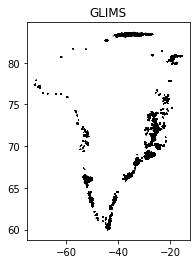

In [28]:
pb_rgi7.plot(edgecolor='k');
plt.title('GLIMS');

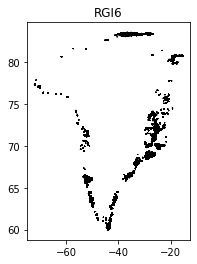

In [29]:
df_ref.plot(edgecolor='k');
plt.title('RGI6');

In [30]:
# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_problem_glaciers'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_problem_glaciers_tar'))

In [31]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
pb_rgi7.to_file(dd + f'RGI{reg:02d}_glims.shp')
df_ref.to_file(dd + f'RGI{reg:02d}_ref.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI05/
RGI05/RGI05_glims.cpg
RGI05/RGI05_glims.dbf
RGI05/RGI05_glims.prj
RGI05/RGI05_glims.shp
RGI05/RGI05_glims.shx
RGI05/RGI05_ref.cpg
RGI05/RGI05_ref.dbf
RGI05/RGI05_ref.prj
RGI05/RGI05_ref.shp
RGI05/RGI05_ref.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_problem_glaciers_tar/RGI05.tar.gz', '-C', '../../rgi7_data/l3_problem_glaciers', 'RGI05'], returncode=0)
